<a href="https://colab.research.google.com/github/BrothaaEww/Sarcasm-Detection/blob/main/sarcasm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd, numpy as np, re, time
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [ ]:
# Loading data from json file
data = pd.read_json('/content/sarcasm.json', lines = False)
print(data)

                                            article_link  \
0      https://www.huffingtonpost.com/entry/versace-b...   
1      https://www.huffingtonpost.com/entry/roseanne-...   
2      https://local.theonion.com/mom-starting-to-fea...   
3      https://politics.theonion.com/boehner-just-wan...   
4      https://www.huffingtonpost.com/entry/jk-rowlin...   
...                                                  ...   
26704  https://www.huffingtonpost.com/entry/american-...   
26705  https://www.huffingtonpost.com/entry/americas-...   
26706  https://www.huffingtonpost.com/entry/reparatio...   
26707  https://www.huffingtonpost.com/entry/israeli-b...   
26708  https://www.huffingtonpost.com/entry/gourmet-g...   

                                                headline  is_sarcastic  
0      former versace store clerk sues over secret 'b...             0  
1      the 'roseanne' revival catches up to our thorn...             0  
2      mom starting to fear son's web series closest ...    

In [ ]:
print(data.isnull().any(axis = 0))

article_link    False
headline        False
is_sarcastic    False
dtype: bool


In [ ]:
# data.rename(columns={'headline': 'text'}, inplace=True)
data.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [ ]:
data.shape

(26709, 3)

In [ ]:
data.is_sarcastic.value_counts()

0    14985
1    11724
Name: is_sarcastic, dtype: int64

In [ ]:
data_serious = data[data['is_sarcastic']==0].head(10)
data_serious

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0
5,https://www.huffingtonpost.com/entry/advancing...,advancing the world's women,0
6,https://www.huffingtonpost.com/entry/how-meat-...,the fascinating case for eating lab-grown meat,0
7,https://www.huffingtonpost.com/entry/boxed-col...,"this ceo will send your kids to school, if you...",0
9,https://www.huffingtonpost.com/entry/fridays-m...,friday's morning email: inside trump's presser...,0
10,https://www.huffingtonpost.com/entry/airline-p...,airline passengers tackle man who rushes cockp...,0
11,https://www.huffingtonpost.com/entry/facebook-...,facebook reportedly working on healthcare feat...,0
12,https://www.huffingtonpost.comhttp://www.thegu...,north korea praises trump and urges us voters ...,0


In [ ]:
data_sarcastic = data[data['is_sarcastic']==1].head(10)
data_sarcastic

,article_link,headline,is_sarcastic
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
8,https://politics.theonion.com/top-snake-handle...,top snake handler leaves sinking huckabee camp...,1
15,https://entertainment.theonion.com/nuclear-bom...,nuclear bomb detonates during rehearsal for 's...,1
16,https://www.theonion.com/cosby-lawyer-asks-why...,cosby lawyer asks why accusers didn't come for...,1
17,https://www.theonion.com/stock-analysts-confus...,"stock analysts confused, frightened by boar ma...",1
20,https://local.theonion.com/courtroom-sketch-ar...,courtroom sketch artist has clear manga influe...,1
21,https://politics.theonion.com/trump-assures-na...,trump assures nation that decision for syrian ...,1
27,https://local.theonion.com/ex-con-back-behind-...,ex-con back behind bar,1
28,https://www.theonion.com/after-careful-conside...,"after careful consideration, bush recommends o...",1


In [ ]:
# Relacing special symbols and digits in headline column
# re stands for Regular Expression
data['headline'] = data['headline'].apply(lambda s : re.sub('[^a-zA-Z]', ' ', s))

In [ ]:
# getting features and labels
features = data['headline']
labels = data['is_sarcastic']

In [ ]:
# Stemming our data
ps = PorterStemmer()
features = features.apply(lambda x: x.split())
features = features.apply(lambda x : ' '.join([ps.stem(word) for word in x]))

In [ ]:
# vectorizing the data with maximum of 5000 features
from sklearn.feature_extraction.text import TfidfVectorizer
tv = TfidfVectorizer(max_features = 5000)
features = list(features)
features = tv.fit_transform(features).toarray()

In [ ]:
# getting training and testing data
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = .2, random_state = 0)

from here


In [ ]:
model = MultinomialNB().fit(features_train, labels_train)
y_pred = model.predict(features_test)

In [ ]:
print('Accuracy:', accuracy_score(labels_test, y_pred)*100)
print('F1 score:', f1_score(labels_test, y_pred, average="macro")*100)
print('ROC AUC:', roc_auc_score(labels_test, y_pred)*100)

Accuracy: 81.84200673904904
F1 score: 81.14934931797384
ROC AUC: 80.70781310418445


In [ ]:
print(classification_report(labels_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.90      0.85      3007
           1       0.84      0.72      0.78      2335

    accuracy                           0.82      5342
   macro avg       0.82      0.81      0.81      5342
weighted avg       0.82      0.82      0.82      5342



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
predictions = model.predict(features_test)

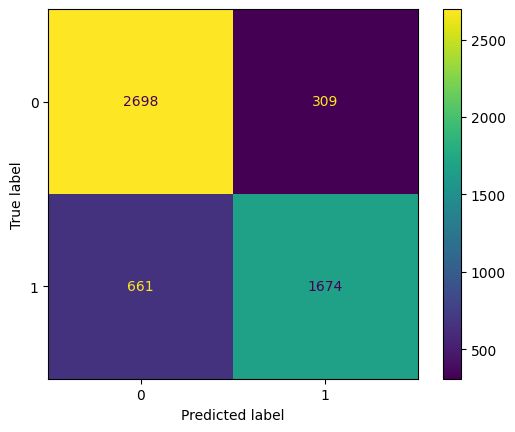

In [ ]:
cm = confusion_matrix(labels_test, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

In [ ]:
results = pd.DataFrame(data={'predicted': y_pred, 'actual': labels_test})
predictions = results.join(data)
print(predictions)

       predicted  actual                                       article_link  \
10646          1       0  https://www.huffingtonpost.com/entry/breaking-...   
1971           1       1  https://www.theonion.com/classmates-com-employ...   
19747          1       1  https://entertainment.theonion.com/woman-unawa...   
14554          0       0  https://www.huffingtonpost.com/entry/donald-tr...   
19329          0       1  https://www.theonion.com/inside-americas-love-...   
...          ...     ...                                                ...   
568            0       0  https://www.huffingtonpost.com/entry/black-rib...   
7983           0       0  https://www.huffingtonpost.com/entry/electric-...   
5289           1       1  https://local.theonion.com/man-just-needs-to-p...   
24239          0       0  https://www.huffingtonpost.com/entry/brooklyn-...   
11281          1       1  https://www.theonion.com/medical-breakthrough-...   

                                                hea

to here

In [ ]:
# model 1:-
# Using linear support vector classifier
lsvc = LinearSVC()
# training the model
lsvc.fit(features_train, labels_train)
# getting the score of train and test data
print('Linear Support Vector')
print(f'train : {lsvc.score(features_train, labels_train)*100}') # 90.93
print(f'test  : {lsvc.score(features_test, labels_test)*100}')   # 83.75
# model 2:-
# Using Gaussuan Naive Bayes
gnb = GaussianNB()
gnb.fit(features_train, labels_train)
print('Gaussian Naive Bayes')
print(f'train : {gnb.score(features_train, labels_train)*100}')  # 78.86
print(f'test  : {gnb.score(features_test, labels_test)*100}')    # 73.80
# model 3:-
# Logistic Regression
lr = LogisticRegression()
lr.fit(features_train, labels_train)
print('Logistic Regression')
print(f'train : {lr.score(features_train, labels_train)*100}')   # 88.16
print(f'test  : {lr.score(features_test, labels_test)*100}')     # 83.08
# model 4:-
# Random Forest Classifier
rfc = RandomForestClassifier(n_estimators = 10, random_state = 0)
rfc.fit(features_train, labels_train)
print('Random Forest Classifier')
print(f'train : {rfc.score(features_train, labels_train)*100}')  # 98.82
print(f'test  : {rfc.score(features_test, labels_test)*100}')    # 79.71

Linear Support Vector
train : 91.5991950203585
test  : 82.27255709472108
Gaussian Naive Bayes
train : 78.40127299106098
test  : 70.591538749532
Logistic Regression
train : 88.31375485561847
test  : 83.05877948333958
Random Forest Classifier
train : 98.96101464875743
test  : 78.22912766754024


another approach


In [ ]:
data = data[["headline", "is_sarcastic"]]
x = np.array(data["headline"])
y = np.array(data["is_sarcastic"])

cv = CountVectorizer()
X = cv.fit_transform(x) # Fit the Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [ ]:
model = LogisticRegression()
# model = RandomForestClassifier(n_estimators = 10, random_state = 0)
model.fit(X_train, y_train)
print('testing accuracy : ')
print(model.score(X_test, y_test)*100)
print('training accuracy : ')
print(model.score(X_train, y_train)*100)

testing accuracy : 
84.12579558217897
training accuracy : 
96.2652688725605


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
cv = CountVectorizer()
X = cv.fit_transform(x) # Fit the Data
user = input("Enter a Text: ")
data = cv.transform([user]).toarray()
output = model.predict(data)
print(output[0])
if output[0]==1:
  print('sarcasm')
elif output[0]==0:
  print(f'not sarcasm')
else:
  print('cannot determine')

Enter a Text: a man can live happily with his wiife
1
sarcasm
